In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import tqdm
import pickle
import numpy as np
import torch
import dnnlib
from torch_utils import distributed as dist
dist.init()
from generate_prior import edm_sampler, ablation_sampler, StackedRandomGenerator

/home/blevac/anaconda3/envs/edm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
net_save = '/csiNAS2/slow/brett/edm_outputs/00037-fastmri_brain_preprocessed_9_25_23-uncond-ddpmpp-edm-gpus4-batch40-fp32-aspect/network-snapshot-004800.pkl'

In [19]:
def gen(network_pkl, outdir, subdirs, seeds, class_idx, max_batch_size, device=torch.device('cuda'), **sampler_kwargs):
    """Generate random images using the techniques described in the paper
    "Elucidating the Design Space of Diffusion-Based Generative Models".

    Examples:

    \b
    # Generate 64 images and save them as out/*.png
    python generate.py --outdir=out --seeds=0-63 --batch=64 \\
        --network=https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl

    \b
    # Generate 1024 images using 2 GPUs
    torchrun --standalone --nproc_per_node=2 generate.py --outdir=out --seeds=0-999 --batch=64 \\
        --network=https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl
    """
    # dist.init()
    num_batches = ((len(seeds) - 1) // (max_batch_size * dist.get_world_size()) + 1) * dist.get_world_size()
    all_batches = torch.as_tensor(seeds).tensor_split(num_batches)
    rank_batches = all_batches[dist.get_rank() :: dist.get_world_size()]

    # Rank 0 goes first.
    if dist.get_rank() != 0:
        torch.distributed.barrier()

    # Load network.
    dist.print0(f'Loading network from "{network_pkl}"...')
    with dnnlib.util.open_url(network_pkl, verbose=(dist.get_rank() == 0)) as f:
        net = pickle.load(f)['ema'].to(device)
    # print(net)
    # Other ranks follow.
    if dist.get_rank() == 0:
        torch.distributed.barrier()

    # Loop over batches.
    dist.print0(f'Generating {len(seeds)} images to "{outdir}"...')
    for batch_seeds in tqdm.tqdm(rank_batches, unit='batch', disable=(dist.get_rank() != 0)):
        torch.distributed.barrier()
        batch_size = len(batch_seeds)
        if batch_size == 0:
            continue

        # Pick latents and labels.
        rnd = StackedRandomGenerator(device, batch_seeds)
        latents = rnd.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)
        class_labels = None
        # print(net.label_dim)
        if net.label_dim:
            class_labels = torch.eye(net.label_dim, device=device)[rnd.randint(net.label_dim, size=[batch_size], device=device)]
        if class_idx is not None:
            class_labels[:, :] = 0
            class_labels[:, class_idx] = 1
        # print(net)

        # Generate images.
        sampler_kwargs = {key: value for key, value in sampler_kwargs.items() if value is not None}
        have_ablation_kwargs = any(x in sampler_kwargs for x in ['solver', 'discretization', 'schedule', 'scaling'])
        sampler_fn = ablation_sampler if have_ablation_kwargs else edm_sampler
        images,img_stack = sampler_fn(net, latents, class_labels, randn_like=rnd.randn_like, **sampler_kwargs)

    return images, img_stack


In [20]:
seeds = [0,1,2,3,4,5,6,7,8,9]
x_out, _ = gen(network_pkl=net_save, outdir='junk', class_idx=None, subdirs='junk', seeds=seeds, max_batch_size=len(seeds))

Loading network from "/csiNAS2/slow/brett/edm_outputs/00037-fastmri_brain_preprocessed_9_25_23-uncond-ddpmpp-edm-gpus4-batch40-fp32-aspect/network-snapshot-004800.pkl"...
Generating 10 images to "junk"...


100%|██████████| 1/1 [00:10<00:00, 10.39s/batch]


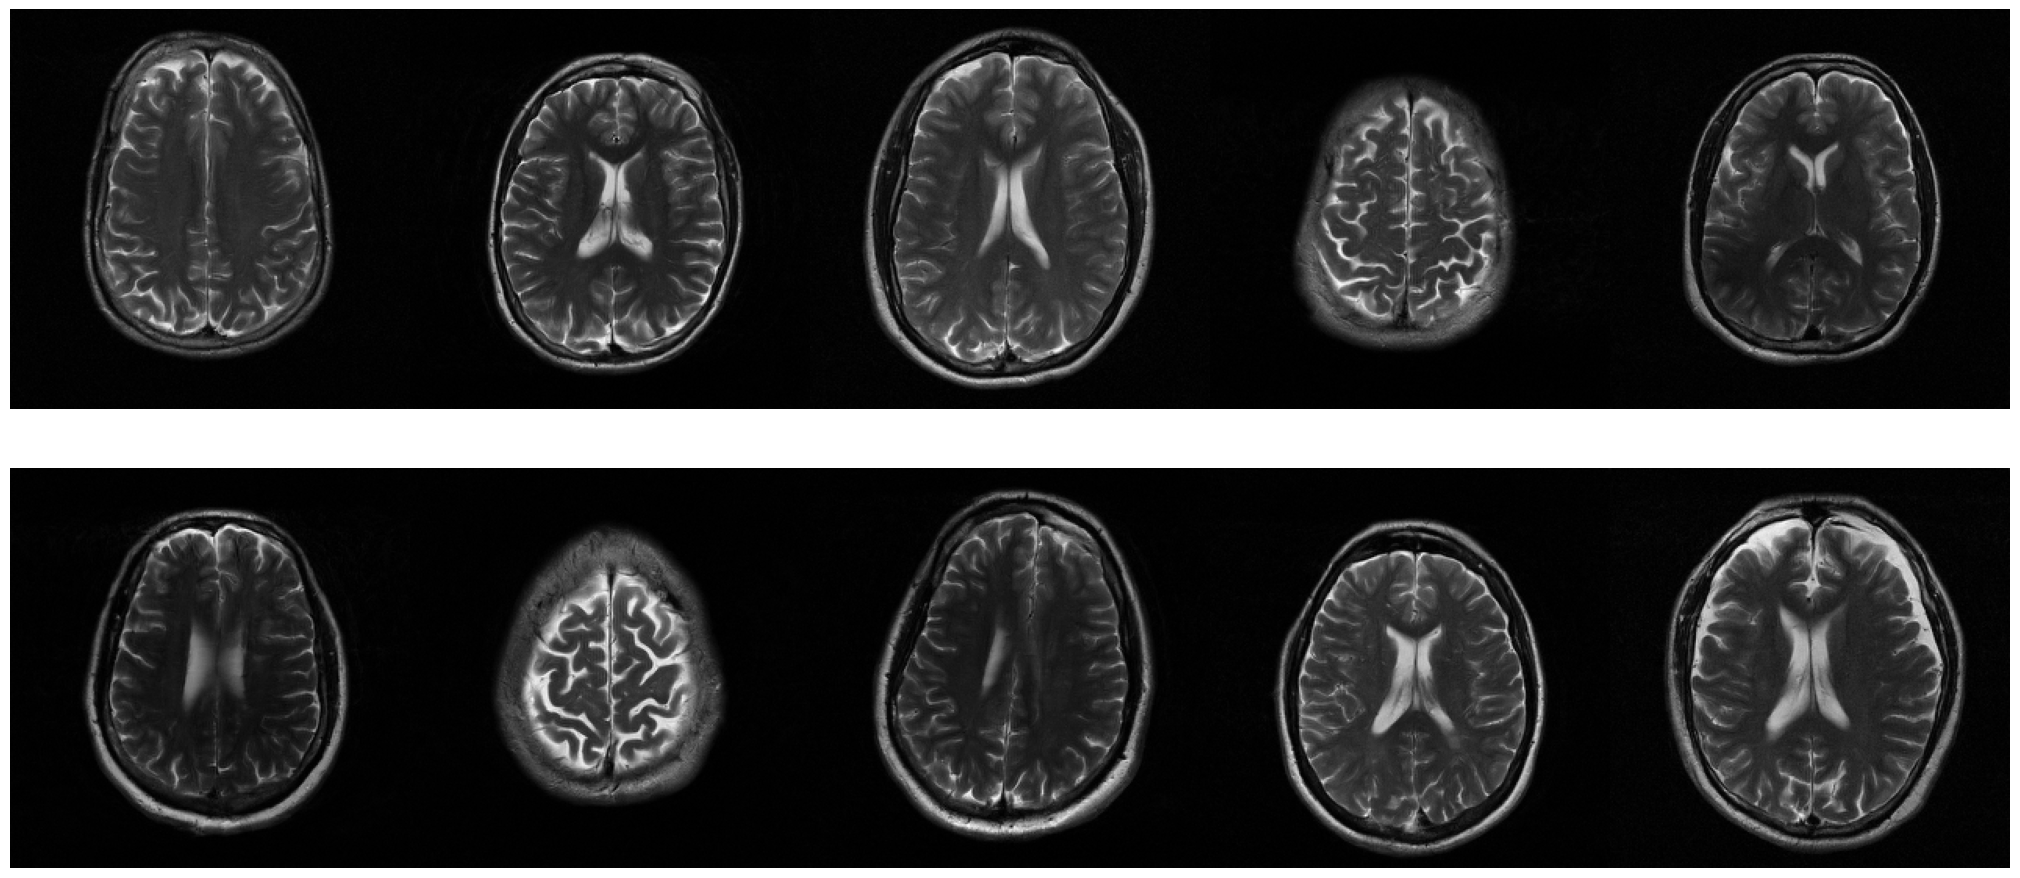

In [22]:
imgs = abs(x_out[:,0,...].cpu()+ 1j*x_out[:,1,...].cpu())

plt.figure(figsize=(20,10))
for i in range(len(seeds)):
    plt.subplot(2,5,i+1)
    plt.imshow(np.flipud(imgs[i]),cmap='gray')
    plt.axis('off')

plt.tight_layout(pad=0.0)